### Imports

In [1]:
from dataclasses import dataclass, field
from functools import lru_cache
from math import pi
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.distributions as dist
from torch.utils.data import DataLoader
from tqdm.auto import trange
import torch.optim as optim
from sklearn.metrics import mean_absolute_error

plt.rcParams["image.cmap"] = "inferno"
DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else "cpu")

### Simulator Setup

In [2]:
def get_meshgrid(resolution, nx, ny, device=None):
    """
    Constructs meshgrids.
    """
    dx = resolution
    dy = resolution

    # Coordinates at pixel centers
    x = torch.linspace(-1, 1, int(nx), device=device) * (nx - 1) * dx / 2
    y = torch.linspace(-1, 1, int(ny), device=device) * (ny - 1) * dy / 2

    # Note difference to numpy (!)
    Y, X = torch.meshgrid((y, x), indexing='ij')

    return X, Y


@dataclass
class Simulator:
    extent: float = 15.0
    """Observation size [deg]"""

    n_pix: int = 64
    """Number of pixels"""

    d_gc: float = 8.3
    """Distance to galactic center [kpc]"""

    sigma_pi0: float = 0.25
    """Length scale associated with spatial variations in pi0 emission [deg]."""

    pi0_disk_height: float = 5.0
    """Disk height for pi0 emission"""

    pi0_disk_radius: float = 20.0
    """Disk radius for pi0 emission"""

    disk_height_ic: float = 5.0
    """Disk height for IC emission [deg]."""

    bubble_smoothing_scale: float = 0.6
    """Smoothing scale for Fermi bubble template [deg]."""

    ps_disk_height: float = 0.3
    """Disk scale height for disk-correlated point sources [kpc]."""

    ps_disk_radius: float = 5.0
    """Disk scale radius for disk-correlated point sources [kpc]."""

    dm_dist_concentration: float = 0.5
    """Steepness of DM emission."""

    dm_dist_scale: float = 5.0
    """Spatial scale of DM emission [deg]."""

    containment_radius: float = 0.8 / 3
    """Very approximate 68% containment radius for PSF [deg]."""

    def __post_init__(self):
        # Image grid
        self.resolution = 2 * self.extent / self.n_pix
        self.X, self.Y = get_meshgrid(self.resolution, self.n_pix, self.n_pix)

        # Gaussian kernel for point spread function used to blur the observation
        X_k, Y_k = get_meshgrid(self.resolution, 5, 5)
        self.psf_kernel = torch.exp(-(X_k**2 + Y_k**2) / (2 * self.containment_radius**2))

        # Kernel for Gaussian process used to model pi0 emission
        pts = torch.stack([self.X.flatten(), self.Y.flatten()])
        d2s = ((pts[:, :, None] - pts[:, None, :]) ** 2).sum(0)
        self.kernel_pi0 = (-d2s / (2 * self.sigma_pi0**2)).exp()

    def sample_pi0_template(self):
        """
        Samples pi0 emission
        """
        # Manually rescale to make it look more realistic
        emission = (self.kernel_pi0 @ torch.randn(self.n_pix**2)).reshape(
            self.n_pix, self.n_pix
        )
        emission = 50 * torch.exp(emission / 8)
        return (
            emission
            * torch.exp(-((self.X / self.pi0_disk_radius) ** 2))
            * torch.exp(-((self.Y / self.pi0_disk_height) ** 2))
        )

    def template_ic(self):
        """
        Gets IC emission, which is smooth and fixed
        """
        return 25 * torch.exp(-self.Y.abs() / self.disk_height_ic)

    def template_bubbles(self):
        """
        Gets Fermi bubbles emission, which is smooth and fixed
        """
        Y_norths = 10.5 * (torch.cosh((-self.X - 1) / 10.5) - 1) + 1
        Y_souths = -8.7 * (torch.cosh((-self.X + 1.7) / 8.7) - 1) - 1
        # Apply some hacky smoothing to the edges of the bubbles
        emission = torch.zeros([self.n_pix, self.n_pix])
        emission[self.Y > 0] = torch.sigmoid(
            (self.Y[self.Y > 0] - Y_norths[self.Y > 0]) / self.bubble_smoothing_scale
        )
        emission[self.Y < 0] = torch.sigmoid(
            (Y_souths[self.Y < 0] - self.Y[self.Y < 0]) / self.bubble_smoothing_scale
        )
        return 3 * emission

    def template_dm(self):
        """
        Computes smooth emission from DM annihilation
        """
        dm_dist = dist.Gamma(self.dm_dist_concentration, 1 / self.dm_dist_scale)
        # Distance to galactic center
        rs = torch.sqrt(self.X**2 + self.Y**2)
        return 100 * dm_dist.log_prob(rs).exp()

    def _sample_ps_gc_xy(self, n: int):
        # Use same distribution as for DM emission
        ps_gc_dist = dist.Gamma(self.dm_dist_concentration + 1, 1 / self.dm_dist_scale)
        rs = ps_gc_dist.sample((n,))
        angles = torch.rand(n) * 2 * pi
        xs = rs * torch.cos(angles)
        ys = rs * torch.sin(angles)
        return xs, ys

    def _sample_ps_disk_xy(self, n: int):
        # Convert to degrees
        scale_radius = self.ps_disk_radius / self.d_gc * 180 / pi
        scale_height = self.ps_disk_height / self.d_gc * 180 / pi

        rs = dist.Exponential(1 / scale_radius).sample((n,))
        ys = dist.Exponential(1 / scale_height).sample((n,))

        # Randomly put pulsars above or below the galactic plane
        ys *= 2 * ((torch.rand(n) > 0.5).float() - 0.5)

        # Project radial coordinate
        angles = 2 * pi * torch.rand(n)
        xs = rs * torch.cos(angles)

        return xs, ys

    def _sample_pss_in_image(self, pos_sampler, n: int):
        # Sample positions until n lie inside the image
        xs, ys = pos_sampler(n)
        while True:
            idx_oob = (xs.abs() > self.extent) | (ys.abs() > self.extent)
            n_oob = idx_oob.sum()
            if n_oob == 0:
                break
            else:
                xs[idx_oob], ys[idx_oob] = pos_sampler(n_oob)

        return xs, ys

    def _pixelate_pss(self, xs, ys, fluxes):
        """
        Creates pixelated map by histogramming point source positions and fluxes.
        """
        # Map onto pixel grid
        bins = torch.linspace(-self.extent, self.extent, self.n_pix + 1)
        return torch.histogramdd(
            torch.stack([ys, xs], 1), bins=(bins, bins), weight=fluxes
        ).hist

    def sample(self) -> dict:
        """
        Simulate all the emission components
        """
        trace = {}

        # Template normalizations
        trace["A_ic"] = torch.rand(1)
        trace["A_pi0"] = torch.rand(1)
        trace["A_bubbles"] = torch.rand(1)
        trace["A_dm"] = torch.rand(1)

        # Sample pi0 template
        trace["template_pi0"] = self.sample_pi0_template()

        # Number of point sources
        n_ps_gc = trace["n_ps_gc"] = torch.randint(low=200, high=800, size=(1,))
        n_ps_disk = trace["n_ps_disk"] = torch.randint(low=1000, high=4000, size=(1,))

        # Sample fluxes
        ps_log_flux_mean = 1.0
        ps_log_flux_scale = 1.2
        dist_ps_fluxes = dist.LogNormal(ps_log_flux_mean, ps_log_flux_scale)
        ps_gc_fluxes = dist_ps_fluxes.sample((n_ps_gc,))
        ps_disk_fluxes = dist_ps_fluxes.sample((n_ps_disk,))
        # Sample positions
        xs_ps_gc, ys_ps_gc = self._sample_pss_in_image(self._sample_ps_gc_xy, n_ps_gc)
        xs_ps_disk, ys_ps_disk = self._sample_pss_in_image(self._sample_ps_disk_xy, n_ps_disk)
        # Pixelate
        trace["flux_ps_gc"] = self._pixelate_pss(xs_ps_gc, ys_ps_gc, ps_gc_fluxes)
        trace["flux_ps_disk"] = self._pixelate_pss(xs_ps_disk, ys_ps_disk, ps_disk_fluxes)

        trace["mu"] = (
            trace["A_ic"] * self.template_ic()
            + trace["A_pi0"] * trace["template_pi0"]
            + trace["A_dm"] * self.template_dm()
            + trace["A_bubbles"] * self.template_bubbles()
            + trace["flux_ps_gc"]
            + trace["flux_ps_disk"]
        )

        # Apply PSF and sample noise
        mu_blurred = torch.nn.functional.conv2d(
            trace["mu"][None, None, :, :], self.psf_kernel[None, None, :, :], padding=2,
        )[0, 0, :, :]

        trace["img"] = dist.Poisson(mu_blurred).sample()


        return trace

    def testsample(self, A_ic, A_pi0, A_bubbles, A_dm) -> dict:
        """
        Simulate all the emission components
        """
        trace = {}

        # Template normalizations
        trace["A_ic"] = A_ic
        trace["A_pi0"] = A_pi0
        trace["A_bubbles"] = A_bubbles
        trace["A_dm"] = A_dm

        # Sample pi0 template
        trace["template_pi0"] = self.sample_pi0_template()

        # Number of point sources
        n_ps_gc = trace["n_ps_gc"] = torch.randint(low=200, high=800, size=(1,))
        n_ps_disk = trace["n_ps_disk"] = torch.randint(low=1000, high=4000, size=(1,))

        # Sample fluxes
        ps_log_flux_mean = 1.0
        ps_log_flux_scale = 1.2
        dist_ps_fluxes = dist.LogNormal(ps_log_flux_mean, ps_log_flux_scale)
        ps_gc_fluxes = dist_ps_fluxes.sample((n_ps_gc,))
        ps_disk_fluxes = dist_ps_fluxes.sample((n_ps_disk,))
        # Sample positions
        xs_ps_gc, ys_ps_gc = self._sample_pss_in_image(self._sample_ps_gc_xy, n_ps_gc)
        xs_ps_disk, ys_ps_disk = self._sample_pss_in_image(self._sample_ps_disk_xy, n_ps_disk)
        # Pixelate
        trace["flux_ps_gc"] = self._pixelate_pss(xs_ps_gc, ys_ps_gc, ps_gc_fluxes)
        trace["flux_ps_disk"] = self._pixelate_pss(xs_ps_disk, ys_ps_disk, ps_disk_fluxes)

        trace["mu"] = (
            trace["A_ic"] * self.template_ic()
            + trace["A_pi0"] * trace["template_pi0"]
            + trace["A_dm"] * self.template_dm()
            + trace["A_bubbles"] * self.template_bubbles()
            + trace["flux_ps_gc"]
            + trace["flux_ps_disk"]
        )

        # Apply PSF and sample noise
        mu_blurred = torch.nn.functional.conv2d(
            trace["mu"][None, None, :, :], self.psf_kernel[None, None, :, :], padding=2,
        )[0, 0, :, :]

        trace["img"] = dist.Poisson(mu_blurred).sample()


        return trace

    def sample_batch(self, n) -> dict:
        samples = [self.sample() for _ in range(n)]
        return torch.utils.data.default_collate(samples)

### Inference
Example observation with each emission component plotted separately. The numbers in the subplots' titles show the mean flux in each pixel.

(The color bars are all the same, which makes some components hard to see. You can change `vmax` to a lower value to make them more visible, or set `vmax=None` to set it automatically.)

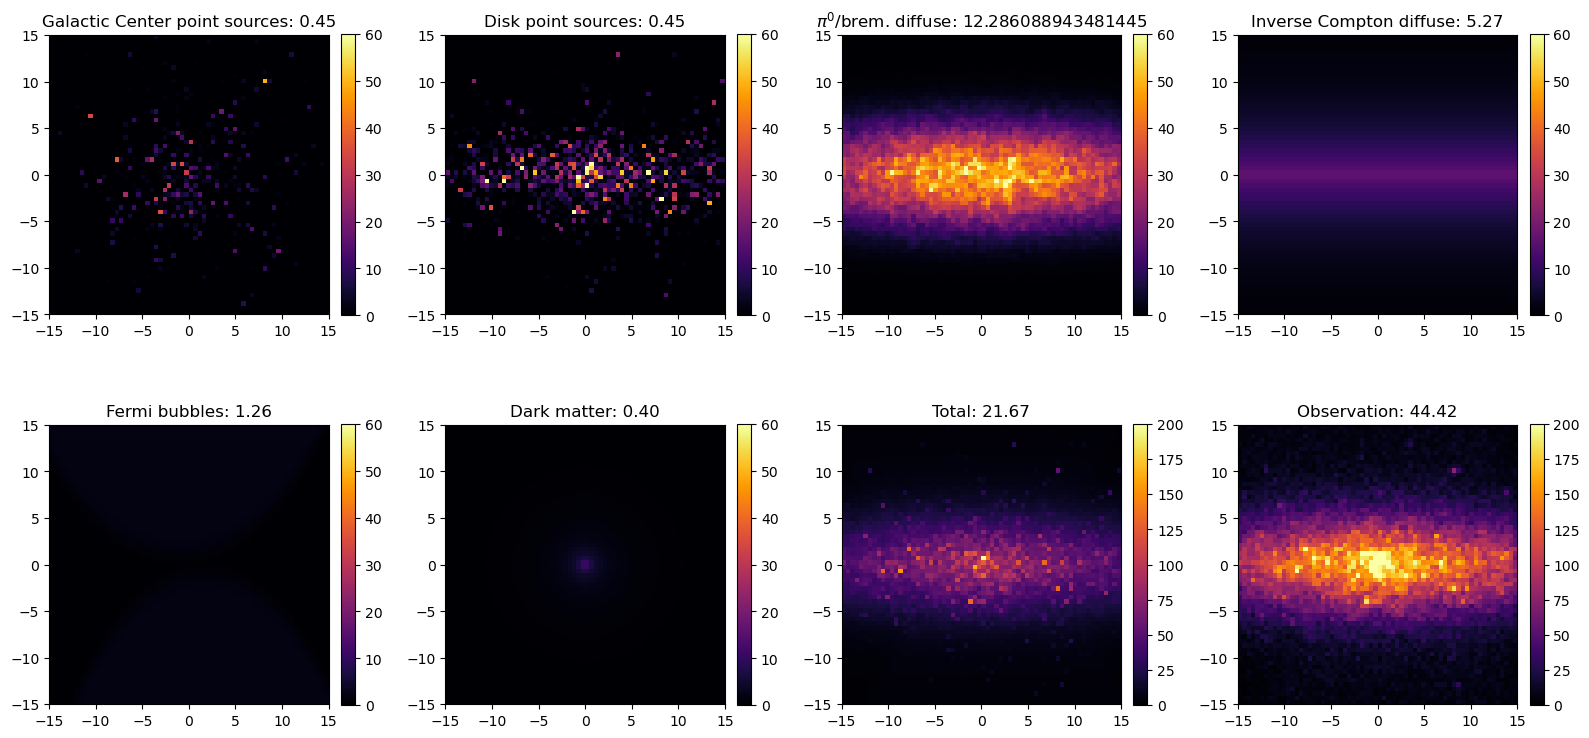

In [3]:
sim = Simulator()
sample = sim.sample()

fig, axes = plt.subplots(2, 4, figsize=(16, 8))

ax = axes[0, 0]
im = ax.pcolormesh(sim.X, sim.Y, sample["flux_ps_gc"], vmin=0, vmax=60)
ax.set_title(f"Galactic Center point sources: {sample['flux_ps_gc'].mean().item():.2f}")
plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

ax = axes[0, 1]
im = ax.pcolormesh(sim.X, sim.Y, sample["flux_ps_disk"], vmin=0, vmax=60)
ax.set_title(f"Disk point sources: {sample['flux_ps_gc'].mean().item():.2f}")
plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

ax = axes[0, 2]
flux_pi0 = sample["A_pi0"] * sample["template_pi0"]
im = ax.pcolormesh(sim.X, sim.Y, flux_pi0, vmin=0, vmax=60)
ax.set_title(r"$\pi^0$/brem. diffuse: " + f"{flux_pi0.mean().item()}")
plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

ax = axes[0, 3]
flux_ic = sample["A_ic"] * sim.template_ic()
im = ax.pcolormesh(sim.X, sim.Y, flux_ic, vmin=0, vmax=60)
ax.set_title(f"Inverse Compton diffuse: {flux_ic.mean().item():.2f}")
plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

ax = axes[1, 0]
flux_bubbles = sample["A_bubbles"] * sim.template_bubbles()
im = ax.pcolormesh(sim.X, sim.Y, flux_bubbles, vmin=0, vmax=60)
ax.set_title(f"Fermi bubbles: {flux_bubbles.mean().item():.2f}")
plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

ax = axes[1, 1]
flux_dm = sample["A_dm"] * sim.template_dm()
im = ax.pcolormesh(sim.X, sim.Y, flux_dm, vmin=0, vmax=60)
ax.set_title(f"Dark matter: {flux_dm.mean().item():.2f}")
plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

ax = axes[1, 2]
im = ax.pcolormesh(sim.X, sim.Y, sample["mu"], vmin=0, vmax=200)
plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
ax.set_title(f"Total: {sample['mu'].mean().item():.2f}")

ax = axes[1, 3]
im = ax.pcolormesh(sim.X, sim.Y, sample["img"], vmin=0, vmax=200)
plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
ax.set_title(f"Observation: {sample['img'].mean().item():.2f}")

for ax in axes.flatten():
    ax.set_aspect("equal")

fig.tight_layout()

### Dataset

In [5]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self, simulator, size: int = 1000):
        self.size = size  # number of simulations in an epoch
        self.simulator = simulator

    def __len__(self):
        return self.size

    def __getitem__(self, index):
        sample = self.simulator.sample()  # generate a sample from the simulator
        # sample["img"] is generally what is observed by network
        # sample["A_dm"] is what we want to infer
        return sample

In [10]:
class ParamNet(nn.Module):
    def __init__(self):
        super(ParamNet, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.fc_layers = nn.Sequential(
            nn.Linear(64 * 16 * 16, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 4)
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)
        x = self.fc_layers(x)
        return x

In [12]:
num_epochs = 10
train_losses = []
val_losses = []

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ParamNet().to(device)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

simulator = Simulator()
batch_size = 32
num_epochs = 10

train_dataset = Dataset(simulator, size=10000)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

optimizer = optim.Adam(model.parameters(), lr=0.001)

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for batch in train_loader:
        img_batch = batch["img"].unsqueeze(1).float().to(device)
        target_params = torch.stack([
            batch["A_ic"],
            batch["A_pi0"],
            batch["A_bubbles"],
            batch["A_dm"],
        ], dim=1).float().to(device)

        target_params = target_params.view(target_params.size(0), -1)

        optimizer.zero_grad()
        outputs = model(img_batch)

        loss = criterion(outputs, target_params)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch {epoch+1}, Loss: {running_loss / len(train_loader):.4f}")
    train_losses.append(running_loss / len(train_loader))

print("Training finished")

KeyboardInterrupt: 

In [ ]:
val_dataset = Dataset(simulator, size=10000)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# dictionary to store true and predicted values for each parameter
param_true_values = {}
param_predicted_values = {}

# validation loop for each parameter
for param_name, param_index in [("A_dm", 0)]:
    avg_val_loss = 0.0
    true_values = []
    predicted_values = []

    # Set model to evaluation mode
    model.eval()

    with torch.no_grad():
        for batch in val_loader:
            img_batch = batch["img"].unsqueeze(1).float().to(device)
            target_params = torch.stack([
                batch["A_ic"],
                batch["A_pi0"],
                batch["A_bubbles"],
                batch["A_dm"],
            ], dim=1).float().to(device)

            outputs = model(img_batch)
            loss = criterion(outputs[:, param_index].unsqueeze(1), target_params[:, param_index])
            avg_val_loss += loss.item()

            true_values.extend(target_params[:, param_index].cpu().numpy())
            predicted_values.extend(outputs[:, param_index].cpu().numpy())

        avg_val_loss /= len(val_loader)

    print(f"Validation Loss for {param_name}: {avg_val_loss:.4f}")
    val_losses.append(avg_val_loss)

    for param_name, true_values in param_true_values.items():
        predicted_values = param_predicted_values[param_name]

        mae = mean_absolute_error(true_values, predicted_values)
        print(f"MAE for {param_name}: {mae:.4f}")


    # store the true and predicted values for each parameter
    param_true_values[param_name] = true_values
    param_predicted_values[param_name] = predicted_values

    # plot the true vs predicted values
    plt.scatter(true_values, predicted_values, label=param_name, color='purple')
    plt.plot([0, 1], [0, 1], color='cyan', linestyle='--')
    plt.xlabel("True Normalization Parameter", fontsize = 15)
    plt.ylabel("Predicted Normalization Parameter", fontsize = 15)
    plt.legend()
    plt.ylim(0, 1.0)
    plt.xlim(0, 1.0)
    plt.title(f"Truth vs Predicted Normalization Parameter for {param_name}", fontsize = 15)
    plt.show()

print("Validation and plotting finished")

In [ ]:
param_true_values["A_dm"] = true_values
param_predicted_values["A_dm"] = predicted_values

num_bins = 20
bin_edges = np.linspace(min(predicted_values), max(predicted_values), num_bins + 1)

bin_indices = np.digitize(predicted_values, bin_edges)

points_in_bins = {i: [] for i in range(1, num_bins + 1)}

for bin_idx in range(1, num_bins + 1):
    indices = np.where(bin_indices == bin_idx)[0]
    for idx in indices:
        points_in_bins[bin_idx].append((true_values[idx], predicted_values[idx]))

plt.figure(figsize=(10, 6))
for bin_key, points in points_in_bins.items():
    true_vals, pred_vals = zip(*points)
    plt.scatter(true_vals, pred_vals, label=f'Bin {bin_key}',s=2)

target_bin_index = 14

bin_edge_low = bin_edges[target_bin_index]
bin_edge_high = bin_edges[target_bin_index + 1]

plt.axhline(y=bin_edge_low, color='red', linestyle='dashed', linewidth=1, label='Bin Border')
plt.axhline(y=bin_edge_high, color='red', linestyle='dashed', linewidth=1, label='Bin Border')

plt.axvline(x=0.7, color='red', linestyle='dashed', linewidth=2)
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.title('Points in Bins')
plt.show()

points_in_target_bin = np.count_nonzero(bin_indices == 11)
print(points_in_target_bin)

In [ ]:
num_bins = 100
bin_edges = np.linspace(min(predicted_values), max(predicted_values), num_bins + 1)

target_predicted_value = 0.6  # replace with target predicted value

bin_index = np.digitize(target_predicted_value, bin_edges)

target_bin_count = np.sum(predicted_values == target_predicted_value)

plt.figure(figsize=(8, 6))
plt.hist(predicted_values, bins=bin_edges, color='blue', alpha=0.7, edgecolor='black')
plt.axvline(x=target_predicted_value, color='red', linestyle='dashed', linewidth=2, label='Target Value, A_dm=0.7')
plt.xlabel('Predicted Values')
plt.ylabel('Frequency')
plt.title('Posterior for A_dm=0.7')
plt.legend()
plt.show()

print(f"Target Predicted Value: {target_predicted_value}")
print(f"Bin Index: {bin_index}")
print(f"Occurrences in Target Bin: {target_bin_count}")

In [ ]:
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.xlim(0,9)
plt.title('Training and Validation Loss')
plt.legend()
plt.show()